### Import Libraries

In [84]:
# Import all libraries needed
import cv2
import os
import zipfile

import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt 

import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.applications.vgg16 import VGG16
from keras.utils import np_utils

### Preprocess Images

In [30]:
# Preprocessing the images
# Randomly rotating and adjusting the brightness of images to create more variations
train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range = 10, brightness_range= (0.1, 0.2))
test_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range = 10, brightness_range= (0.1, 0.2))

root = '/Users/anqizhou/Documents/GitHub/lfw_dataset/'

training_set = train_datagen.flow_from_directory(root+'cnn_train/',
                                                 batch_size = 320, # length of the training set
                                                 target_size = (250, 250),
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical',
                                                 shuffle = True)
val_set = test_datagen.flow_from_directory(root+'cnn_val/',
                                           batch_size = 154,
                                           target_size = (250, 250),
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True)

Found 320 images belonging to 10 classes.
Found 154 images belonging to 10 classes.


### Data Augmentation

In [23]:
# Helper function to extract labels for classes
def extract_y(y_dummy):
    label_vector = []
    i = 0
    while (i < len(y_dummy)):
        j = 0
        while (j < len(y_dummy[i])):
            if (y_dummy[i][j]):
                label_vector.append(j)
                break
            j += 1  
        i += 1
    return label_vector

In [33]:
# Data Augmentation: increase the size of the training set to prepare for PCA
dataAugmentTrain = 2
dataAugmentTest = 1

# Extract y_train, y_test
x_train, dummy_vector = training_set.next()
y_train = extract_y(dummy_vector)
x_test, dummy_vector = val_set.next()
y_test = extract_y(dummy_vector)

while dataAugmentTrain > 0:
    x_train2, dummy_vector = training_set.next()
    y_train2 = extract_y(dummy_vector)
    x_train = np.append(x_train, x_train2, axis=0)
    y_train = np.append(y_train, y_train2, axis=0)
    dataAugmentTrain -= 1

while dataAugmentTest > 0:
    x_test2, dummy_vector = val_set.next()
    y_test2 = extract_y(dummy_vector)
    x_test = np.append(x_test, x_test2, axis=0)
    y_test = np.append(y_test, y_test2, axis=0)
    dataAugmentTest -= 1

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(960, 250, 250, 3)
(308, 250, 250, 3)
(960,)
(308,)


### VGG16 Model as Feature Extractor

In [36]:
# VGG16 Model
def getVGG16Model():
    vgg_model = VGG16(weights='imagenet', input_shape=(250, 250, 3), include_top=False)
    
    for layer in vgg_model.layers[:]:
        layer.trainable = False

    vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    vgg_model.summary()

    return vgg_model

model = getVGG16Model()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [37]:
# Extract the features of the training set
x_train_feature_extracted = model.predict(x_train)
x_train_feature_extracted.shape

30/30 [==============================] - 230s 8s/step


(960, 7, 7, 512)

In [38]:
# PCA: reduce dimensionality
from sklearn.decomposition import PCA

pca_components = 384 
X_train_PCA = x_train_feature_extracted.reshape(x_train_feature_extracted.shape[0], -1)
pca = PCA(n_components = pca_components, whiten = True).fit(X_train_PCA)
X = pca.transform(X_train_PCA)

In [39]:
# SVM: classifier
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(X, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [40]:
x_test_feature_extracted = model.predict(x_test)
x_test = pca.transform(x_test_feature_extracted.reshape(x_test_feature_extracted.shape[0], -1))
y_pred = clf.predict(x_test)

10/10 [==============================] - 53s 5s/step


In [86]:
from sklearn import metrics

print ("Accuracy = ", metrics.accuracy_score(y_test, y_pred))
print ("Classification Report:\n")
print (metrics.classification_report(y_test, y_pred, zero_division=0))

Accuracy =  0.9058441558441559
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.93      0.93      0.93        28
           2       0.96      0.85      0.90        26
           3       0.68      0.71      0.69        24
           4       0.89      0.92      0.91        26
           5       0.85      0.91      0.88        32
           6       0.93      1.00      0.96        38
           7       0.91      0.94      0.93        34
           8       0.97      1.00      0.99        36
           9       0.86      0.69      0.77        26

    accuracy                           0.91       308
   macro avg       0.90      0.89      0.89       308
weighted avg       0.91      0.91      0.90       308



In [79]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Define the pipeline
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('mlpclassifier', MLPClassifier())
])

# Define the parameter grid
params = {
    'mlpclassifier__hidden_layer_sizes': [(100,), (200,), (300,), (400,), (500,), (600,), (700,), (800,)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Perform grid search
from sklearn.model_selection import GridSearchCV
grid_search_mlp = GridSearchCV(pipeline, params, cv=5)
grid_search_mlp.fit(X, y_train)

# Get the best parameters and score
best_params = grid_search_mlp.best_params_
best_score = grid_search_mlp.best_score_

# print the best hyperparameters and the corresponding accuracy score
print("Best parameters:", best_params)
print("Best accuracy:", best_score)

Best parameters: {'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (700,)}
Best accuracy: 0.9802083333333332


In [85]:
# get the best classifier from the grid search and fit it on the training data
best_classifier_mlp = grid_search_mlp.best_estimator_
best_classifier_mlp.fit(X, y_train)

# evaluate the best classifier on the test data
y_pred_mlp = best_classifier_mlp.predict(x_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, np.array(y_pred_mlp)))
print ("Classification Report:\n")
print (metrics.classification_report(y_test, y_pred_mlp, zero_division=0))

Accuracy =  0.9090909090909091
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.90      0.93      0.91        28
           2       1.00      0.85      0.92        26
           3       0.67      0.83      0.74        24
           4       0.92      0.88      0.90        26
           5       0.88      0.94      0.91        32
           6       0.95      1.00      0.97        38
           7       0.91      0.94      0.93        34
           8       0.97      1.00      0.99        36
           9       0.84      0.62      0.71        26

    accuracy                           0.91       308
   macro avg       0.90      0.90      0.90       308
weighted avg       0.91      0.91      0.91       308



In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a random forest classifier
rfc = RandomForestClassifier()

# Set the hyperparameters to be tuned
params = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid=params, cv=5)
grid_search.fit(X, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
Best score:  0.9989583333333332


In [56]:
# get the best classifier from the grid search and fit it on the training data
best_classifier_rf = grid_search.best_estimator_
best_classifier_rf.fit(X, y_train)

# evaluate the best classifier on the test data
y_pred_rf = best_classifier_rf.predict(x_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, y_pred_rf))
print ("Classification Report:\n")
print (metrics.classification_report(y_test, y_pred_rf, zero_division=0))

Accuracy =  0.7467532467532467
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        38
           1       0.86      0.68      0.76        28
           2       0.90      0.73      0.81        26
           3       0.36      0.67      0.47        24
           4       0.88      0.54      0.67        26
           5       0.86      0.78      0.82        32
           6       0.68      0.89      0.77        38
           7       0.76      0.47      0.58        34
           8       0.92      1.00      0.96        36
           9       0.63      0.65      0.64        26

    accuracy                           0.75       308
   macro avg       0.77      0.73      0.74       308
weighted avg       0.78      0.75      0.75       308



### Data Visualization

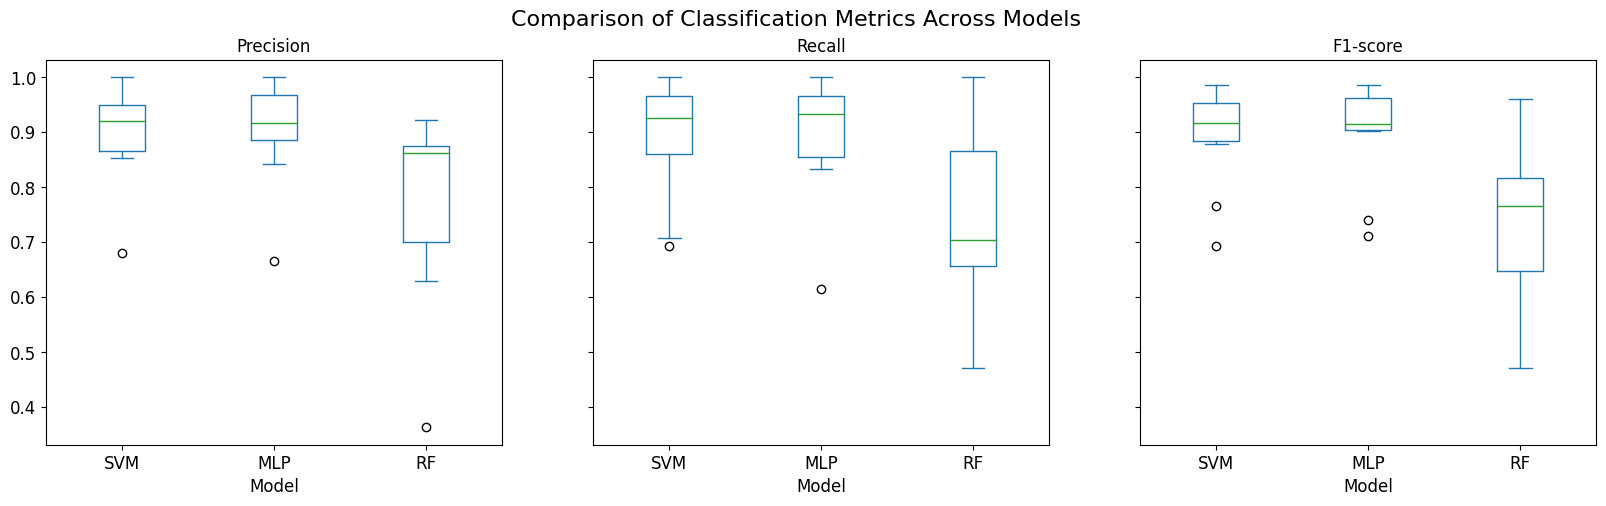

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary for three models
model_reports = {}
model_reports['SVM'] = metrics.classification_report(y_test, y_pred, output_dict=True)
model_reports['MLP'] = metrics.classification_report(y_test, y_pred_mlp, output_dict=True)
model_reports['RF'] = metrics.classification_report(y_test, y_pred_rf, output_dict=True)

# Create a list of metric names for the box plots
metrics_lst = ['precision', 'recall', 'f1-score']

# Create a list of class names for the box plots
classes_lst = [str(i) for i in range(10)]

# Create a dictionary to store the data for each metric and model
data = {}
for metric in metrics_lst:
    data[metric] = {}
    for model_name in model_reports.keys():
        data[metric][model_name] = []
        for c in classes_lst:
            data[metric][model_name].append(model_reports[model_name][c][metric])

# Create subplots for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_lst), figsize=(20, 5), sharey=True)

# Generate box plots for each metric and model
for i, metric in enumerate(metrics_lst):
    df = pd.DataFrame(data[metric], index=classes_lst)
    ax = df.plot(kind='box', ax=axes[i], title=metric.capitalize(), grid=False, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)

# Set the title of the figure
fig.suptitle('Comparison of Classification Metrics Across Models', fontsize=16)

# Show the plot
plt.show()

In [124]:
dfs = pd.read_excel('data.xlsx', sheet_name='Sheet3', header=1)
dfs = dfs.drop('Names', axis=1)
dfs

,Baseline Model,Model A,Model B,Baseline Model.1,Model A.1,Model B.1,Baseline Model.2,Model A.2,Model B.2
0,0.93,0.94,0.98,1.00,1.00,1.00,0.46,0.54,0.85
1,0.94,0.97,0.96,0.71,0.88,0.78,0.56,0.78,0.78
2,0.92,0.92,0.94,0.57,0.56,1.00,0.44,0.56,0.33
3,0.85,0.86,0.90,0.25,0.40,0.53,0.18,0.55,0.73
4,0.90,0.92,0.94,0.54,0.67,0.86,0.64,0.55,0.55
5,0.98,0.91,0.95,0.86,0.42,0.62,0.86,0.71,0.71
6,0.92,0.90,0.92,0.40,0.33,0.44,0.29,0.43,0.57
7,0.92,0.93,0.94,0.62,0.71,0.67,0.50,0.50,0.80
8,0.90,0.93,0.98,0.58,0.69,1.00,0.58,0.75,0.83
9,0.76,0.88,0.89,0.26,0.45,0.50,0.64,0.45,0.73


In [127]:
dfs.iloc[:,0]

0    0.93
1    0.94
2    0.92
3    0.85
4    0.90
5    0.98
6    0.92
7    0.92
8    0.90
9    0.76
Name: Baseline Model, dtype: float64

In [131]:
# Reformat into dictionary
data_prev = {}
metric_lst_prev = ['Accuracy', 'Precision', 'Recall']
model_names = ['Baseline Model', 'Model A', 'Model B']

for x in range(3):
    data_prev[metric_lst_prev[x]] = {}

for i in range(3):
    data_prev['Accuracy'][model_names[i]] = list(dfs.iloc[:,i])

for i in range(3,6):
    data_prev['Precision'][model_names[i%3]] = list(dfs.iloc[:,i])
    
for i in range(6,9):
    data_prev['Recall'][model_names[i%3]] = list(dfs.iloc[:,i])
data_prev

{'Accuracy': {'Baseline Model': [0.93,
   0.94,
   0.92,
   0.85,
   0.9,
   0.98,
   0.92,
   0.92,
   0.9,
   0.76],
  'Model A': [0.94, 0.97, 0.92, 0.86, 0.92, 0.91, 0.9, 0.93, 0.93, 0.88],
  'Model B': [0.98, 0.96, 0.94, 0.9, 0.94, 0.95, 0.92, 0.94, 0.98, 0.89]},
 'Precision': {'Baseline Model': [1.0,
   0.71,
   0.57,
   0.25,
   0.54,
   0.86,
   0.4,
   0.62,
   0.58,
   0.26],
  'Model A': [1.0, 0.88, 0.56, 0.4, 0.67, 0.42, 0.33, 0.71, 0.69, 0.45],
  'Model B': [1.0, 0.78, 1.0, 0.53, 0.86, 0.62, 0.44, 0.67, 1.0, 0.5]},
 'Recall': {'Baseline Model': [0.46,
   0.56,
   0.44,
   0.18,
   0.64,
   0.86,
   0.29,
   0.5,
   0.58,
   0.64],
  'Model A': [0.54, 0.78, 0.56, 0.55, 0.55, 0.71, 0.43, 0.5, 0.75, 0.45],
  'Model B': [0.85, 0.78, 0.33, 0.73, 0.55, 0.71, 0.57, 0.8, 0.83, 0.73]}}

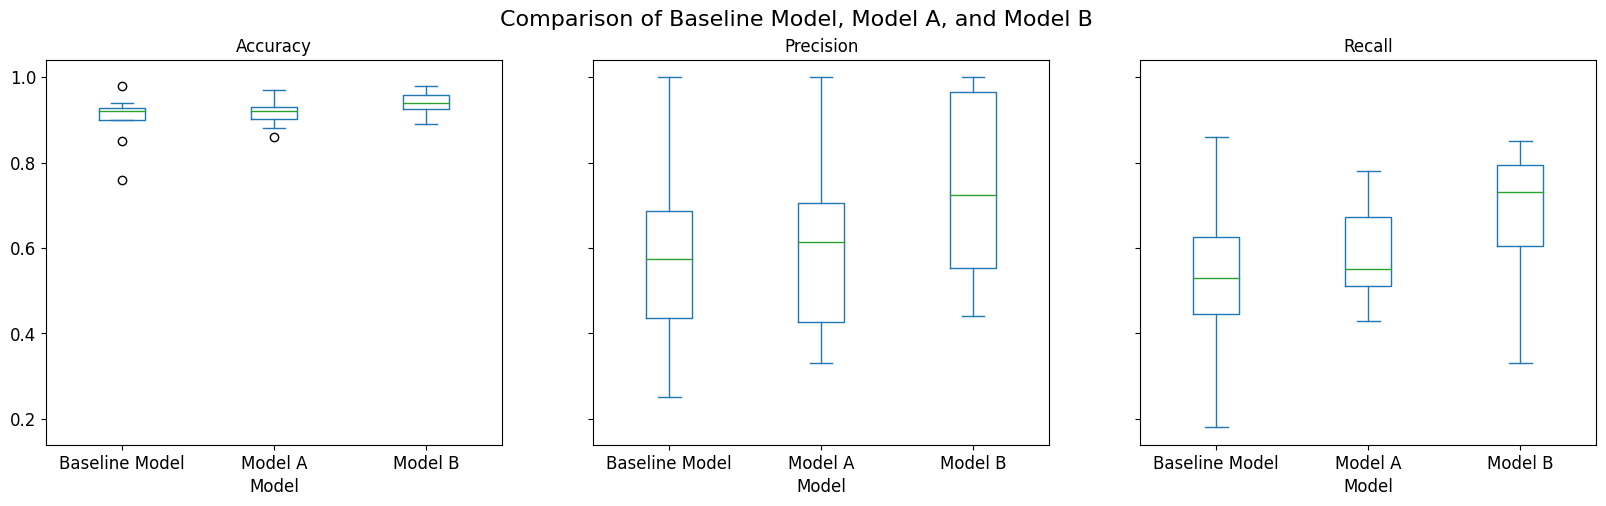

In [139]:
# Create subplots for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(metric_lst_prev), figsize=(20, 5), sharey=True)

# Generate box plots for each metric and model
for i, metric in enumerate(metric_lst_prev):
    df = pd.DataFrame(data_prev[metric], index=classes_lst)
    ax = df.plot(kind='box', ax=axes[i], title=metric.capitalize(), grid=False, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
#     for box in axes[i].artists:
#         box.set_edgecolor('red')
#         box.set_facecolor('white')

# Set the title of the figure
fig.suptitle('Comparison of Baseline Model, Model A, and Model B', fontsize=16)

# Show the plot
plt.show()